# Issue #1663 (TensorFlow)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

import os
import glob
import gzip
import pickle


########## Utility methods ###########

'''
Convert BGR to RGB
'''
def bgr_to_rgb(x):
    return x[:, :, ::-1]

'''
Predict top 5 classes for image
'''
def predict_model(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name = prediction_decode[i][1]
        name = name.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)

#### Hyperparameters

In [2]:
target_name = 'goldfish, Carassius auratus'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  = 1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 500

#### Model definition

In [3]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-11-04 12:36:16.327445: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-04 12:36:16.327599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## ImageNet images

Load images, convert RGB to BGR. Further preprocessing passed to TensorFlowV2Classifier: zero-center each color channel with respect to ImageNet dataset [without scaling](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input#:~:text=The%20images%20are%20converted%20from%20RGB%20to%20BGR%2C%20then%20each%20color%20channel%20is%20zero%2Dcentered%20with%20respect%20to%20the%20ImageNet%20dataset%2C%20without%20scaling).

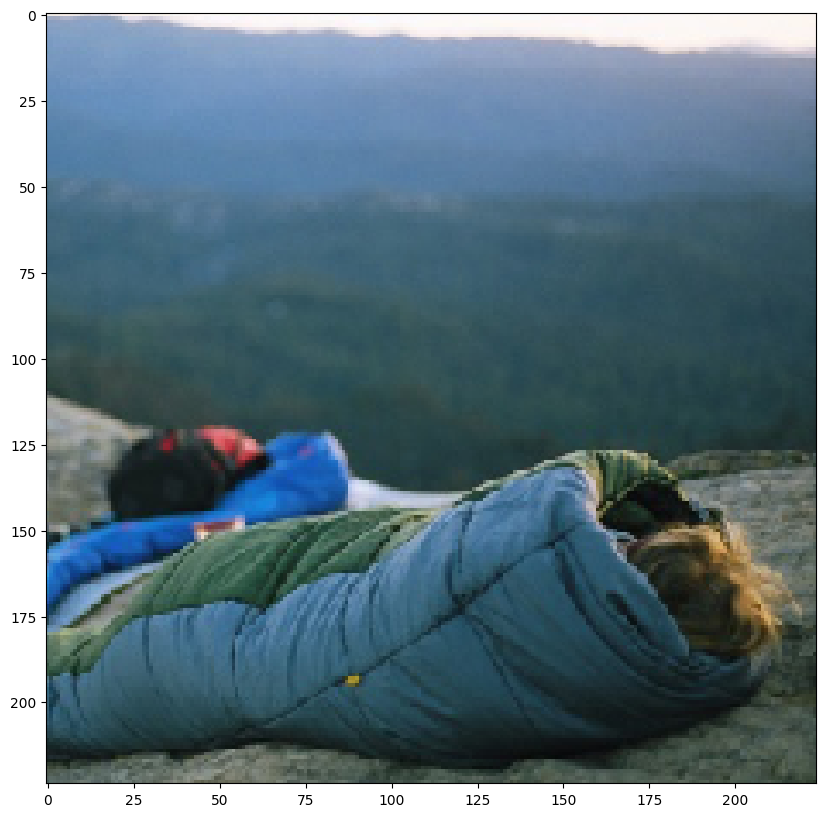

Predictions:
sleeping_bag  0.98
parachute     0.01
binoculars    0.00
balloon       0.00
mountain_tent 0.00


In [4]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

predict_model(tfc, images[0])

#### Generate Adversarial Patch

Adversarial Patch TensorFlow v2:   0%|          | 0/500 [00:00<?, ?it/s]

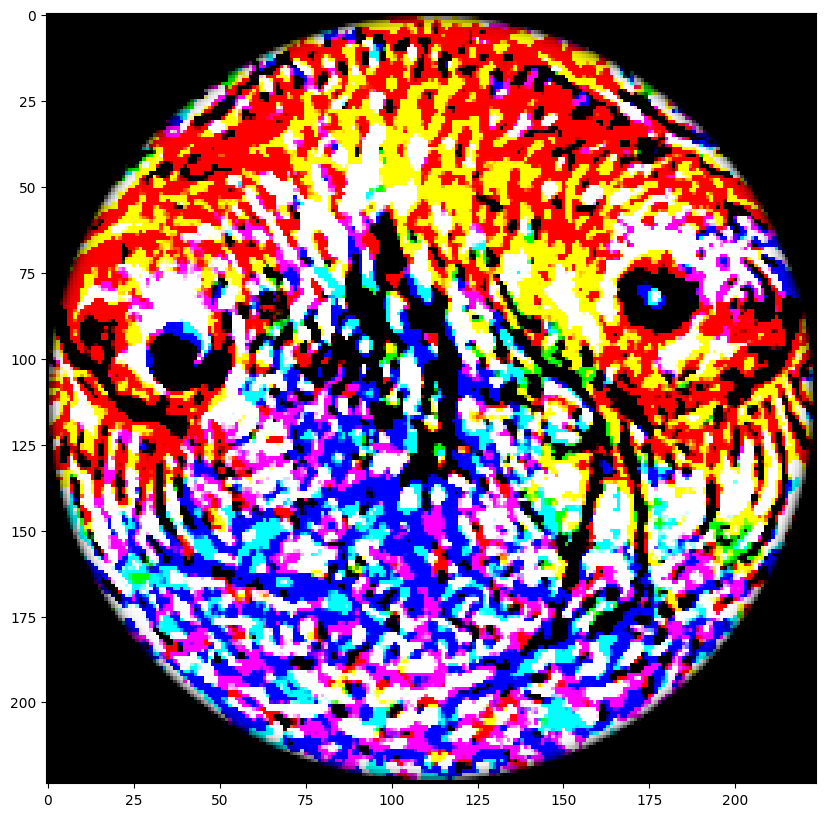

In [5]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint))

#### Apply the adversarial patch to images

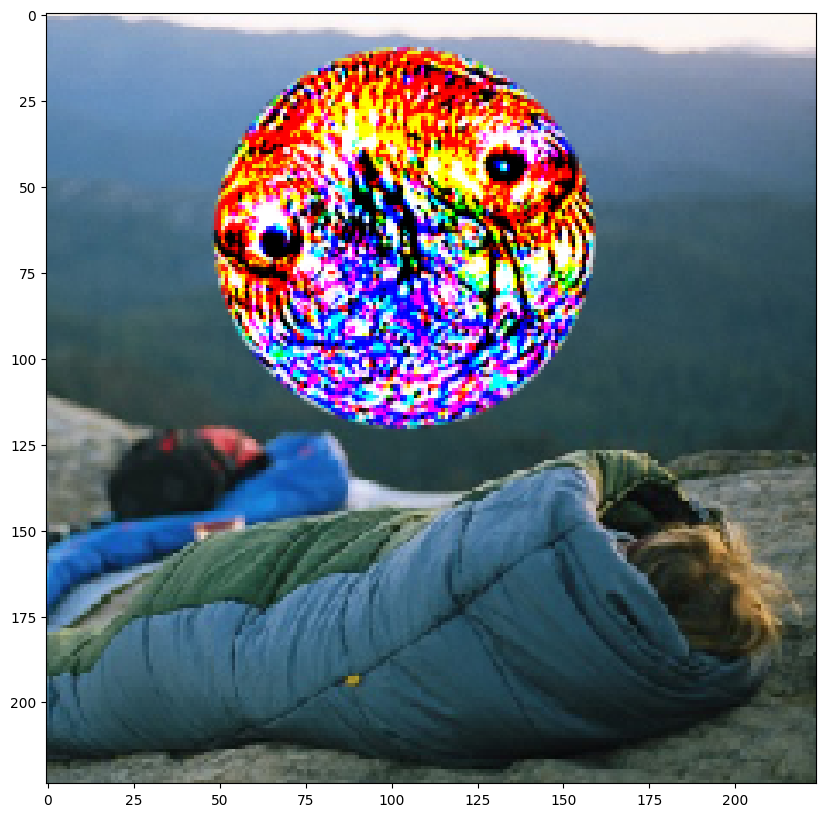

Predictions:
goldfish   1.00
cock       0.00
puffer     0.00
Airedale   0.00
loggerhead 0.00


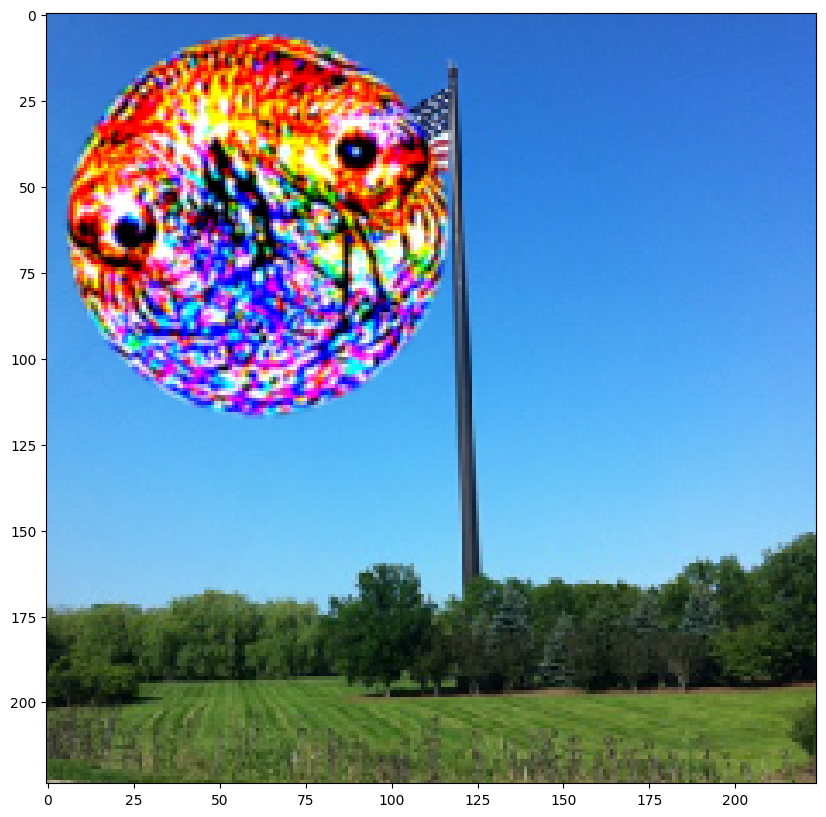

Predictions:
goldfish   1.00
worm_fence 0.00
pinwheel   0.00
puffer     0.00
tench      0.00


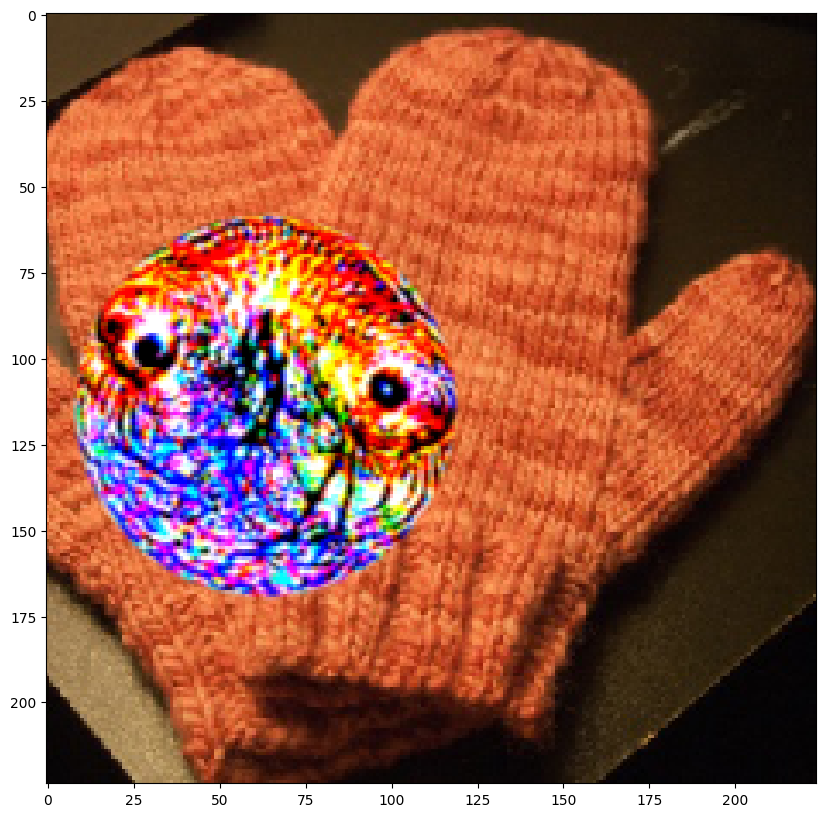

Predictions:
goldfish   0.99
mitten     0.00
piggy_bank 0.00
teddy      0.00
puffer     0.00


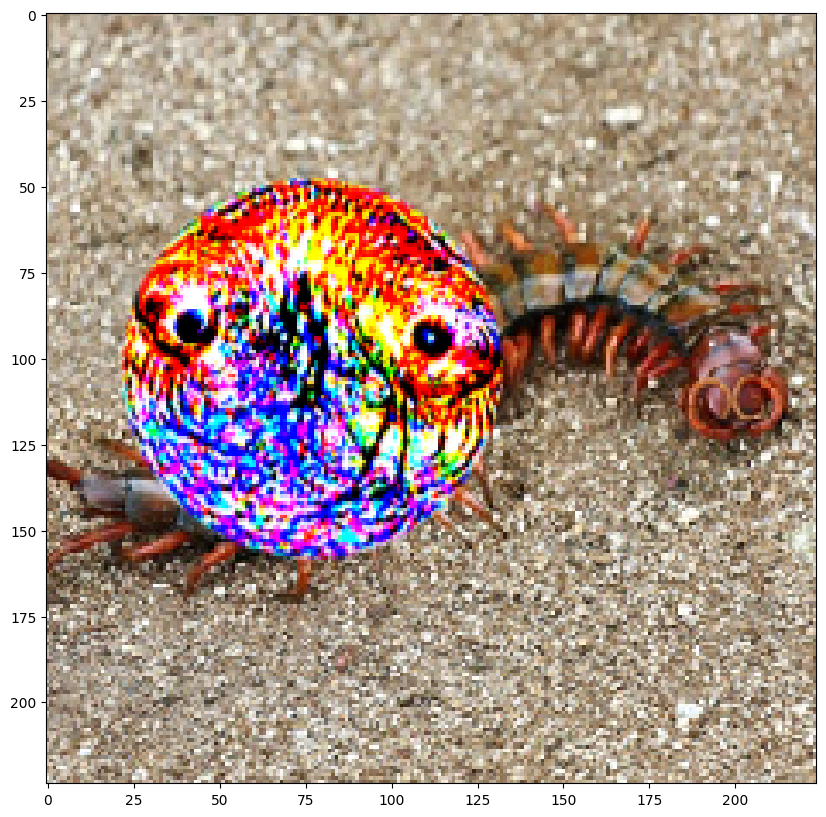

Predictions:
goldfish    0.68
ladybug     0.20
puffer      0.02
centipede   0.02
leaf_beetle 0.01


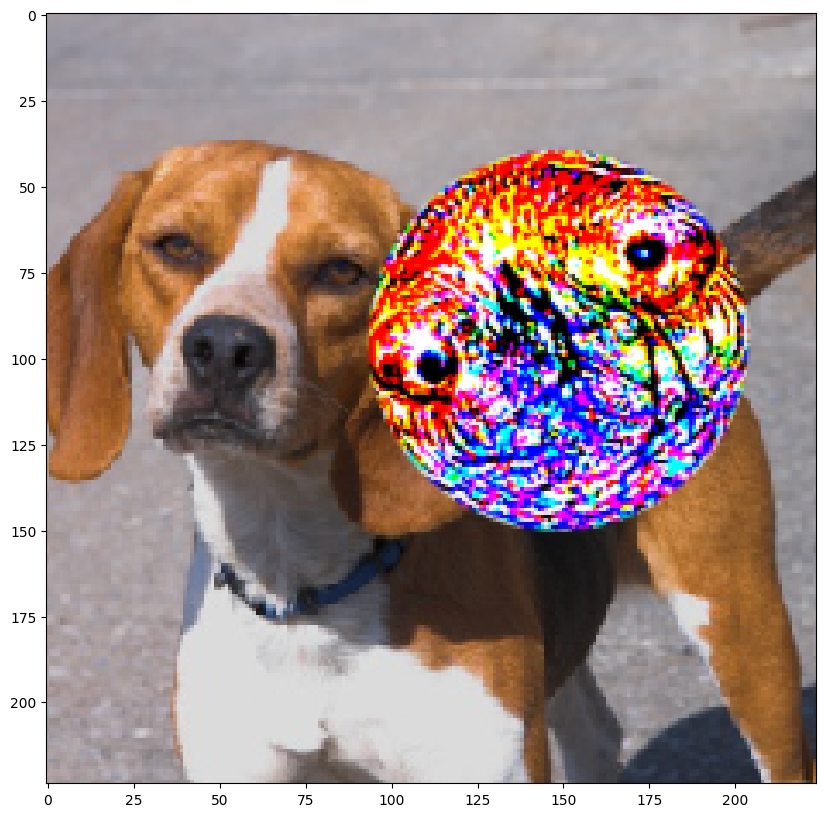

Predictions:
basenji      0.34
beagle       0.18
goldfish     0.16
Walker_hound 0.03
EntleBucher  0.02


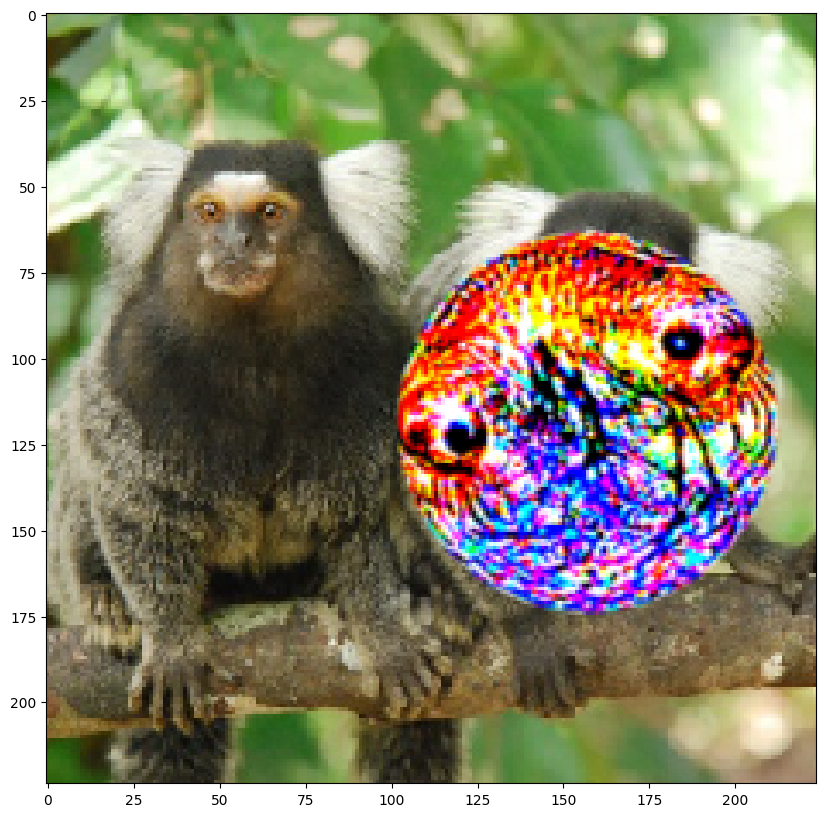

Predictions:
marmoset 0.76
goldfish 0.11
titi     0.10
ladybug  0.01
langur   0.00


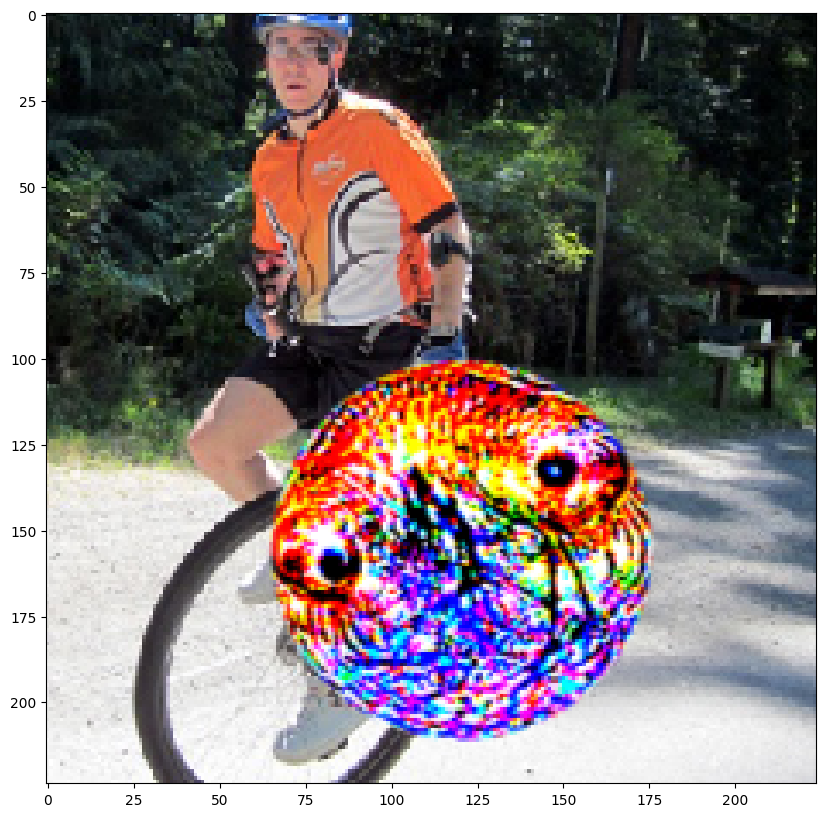

Predictions:
goldfish   1.00
piggy_bank 0.00
tench      0.00
starfish   0.00
puffer     0.00


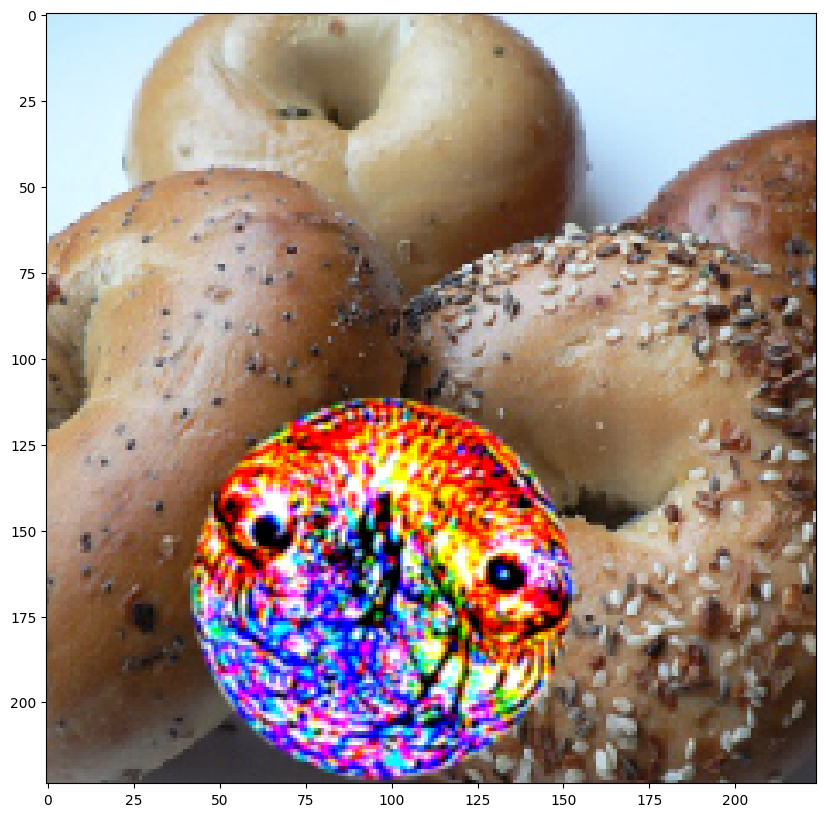

Predictions:
bagel      0.80
goldfish   0.20
ladybug    0.00
pretzel    0.00
piggy_bank 0.00


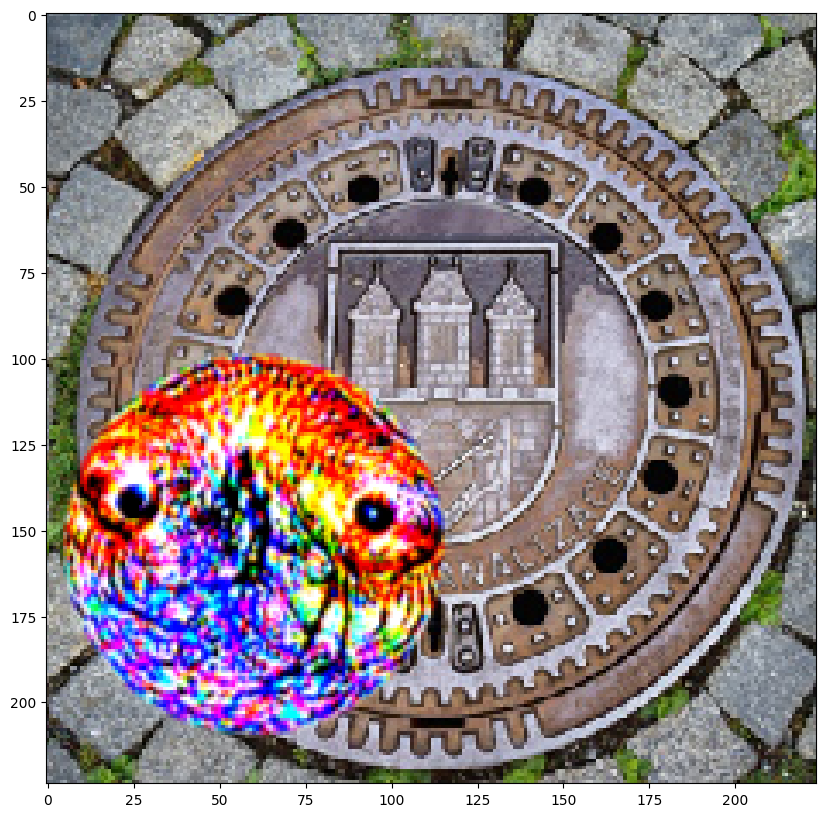

Predictions:
manhole_cover 0.65
goldfish      0.34
ladybug       0.00
brass         0.00
reel          0.00


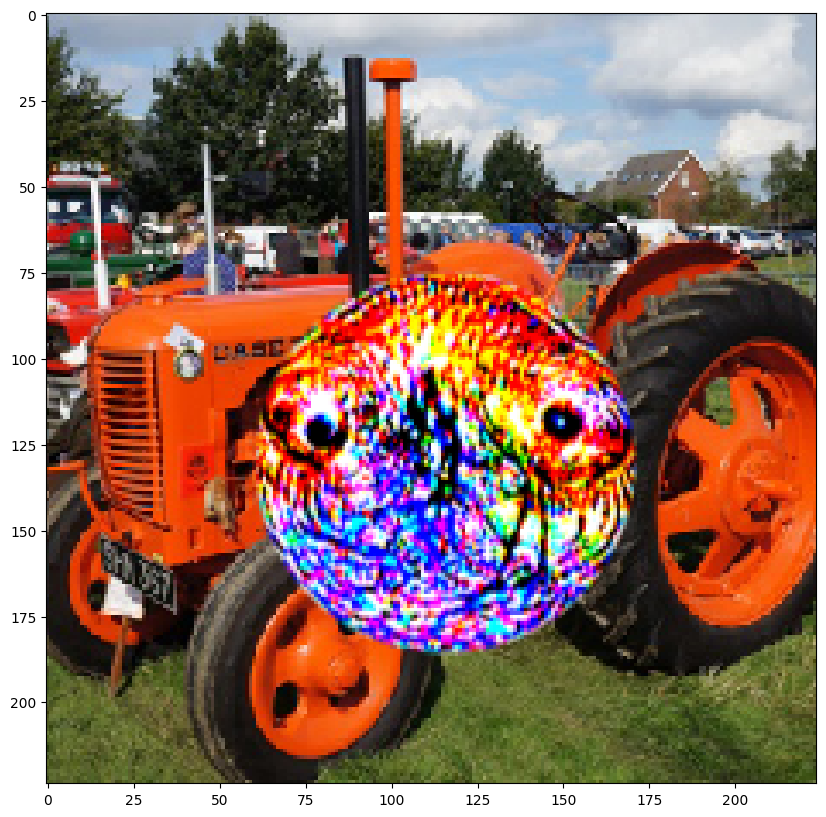

Predictions:
tractor   0.64
thresher  0.16
plow      0.07
harvester 0.07
goldfish  0.02


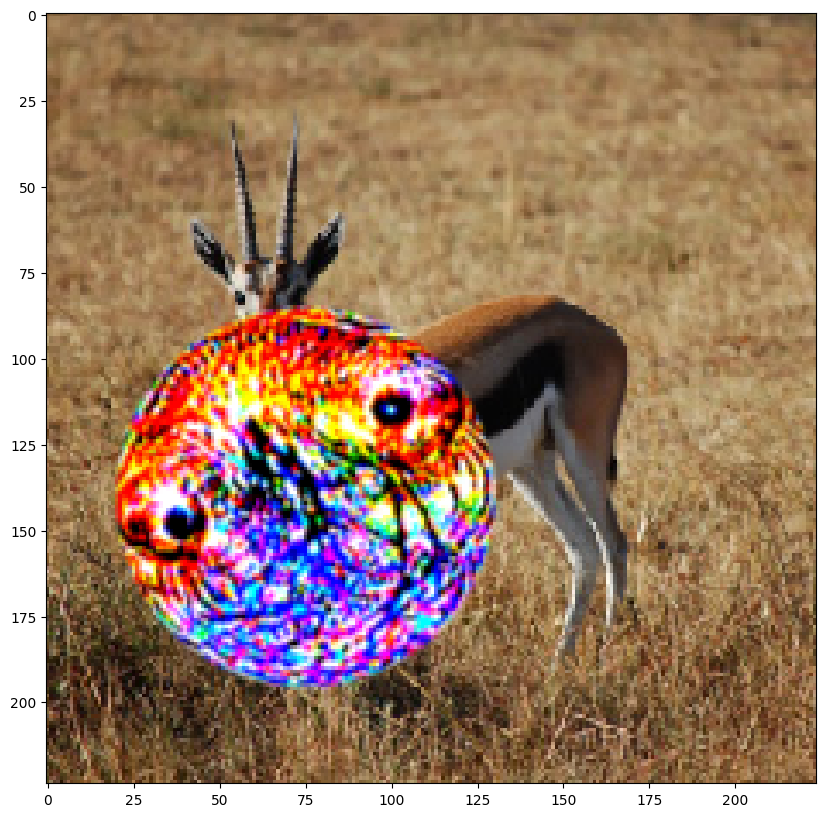

Predictions:
goldfish 0.45
gazelle  0.10
ladybug  0.07
basenji  0.04
cock     0.03


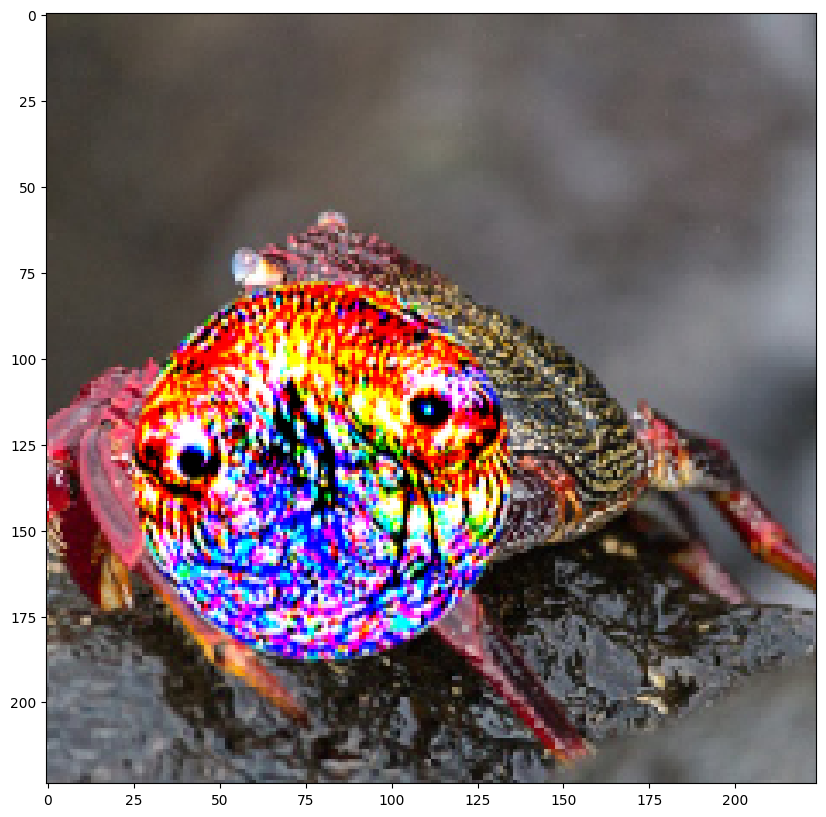

Predictions:
goldfish   0.99
mud_turtle 0.00
agama      0.00
rock_crab  0.00
crayfish   0.00


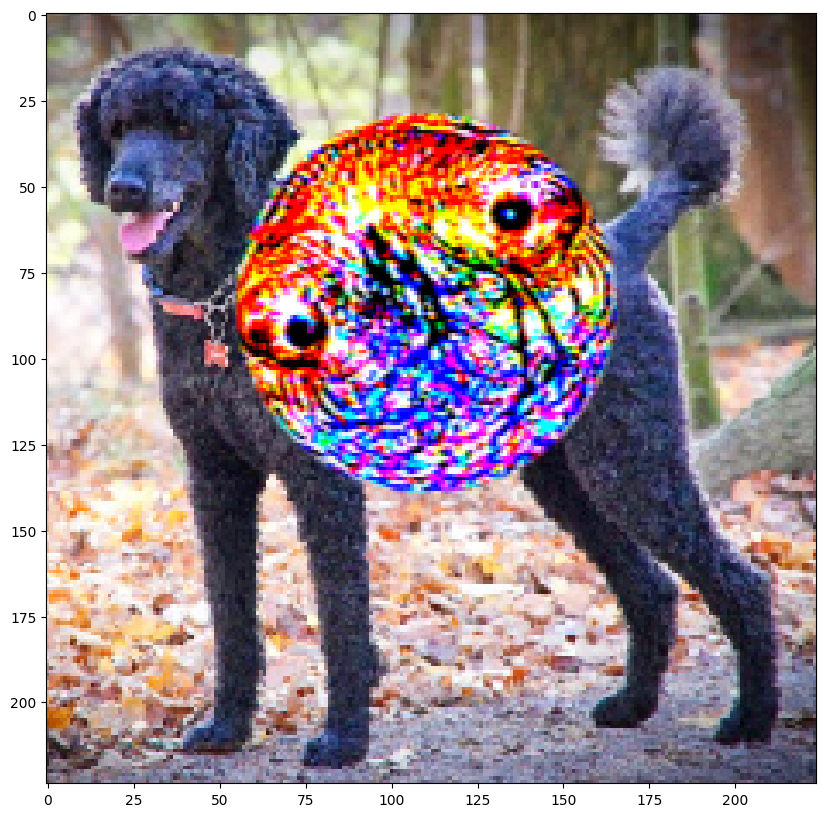

Predictions:
standard_poodle        0.72
miniature_poodle       0.08
toy_poodle             0.07
goldfish               0.04
curly-coated_retriever 0.02


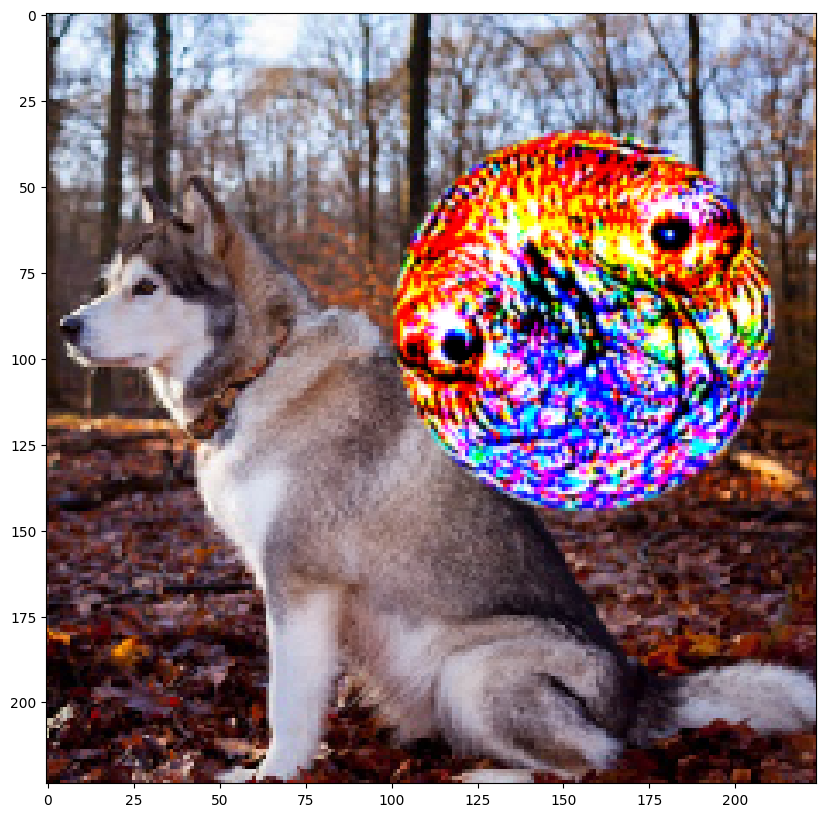

Predictions:
goldfish           0.42
Siberian_husky     0.23
malamute           0.19
Eskimo_dog         0.10
Norwegian_elkhound 0.03


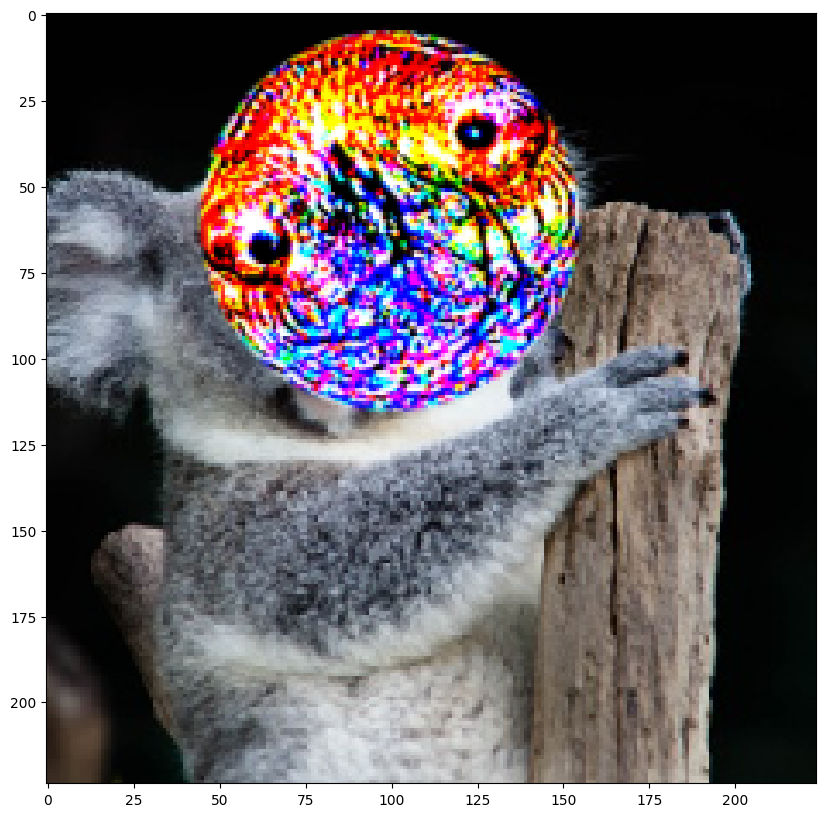

Predictions:
goldfish   0.93
teddy      0.02
koala      0.02
puffer     0.01
piggy_bank 0.00


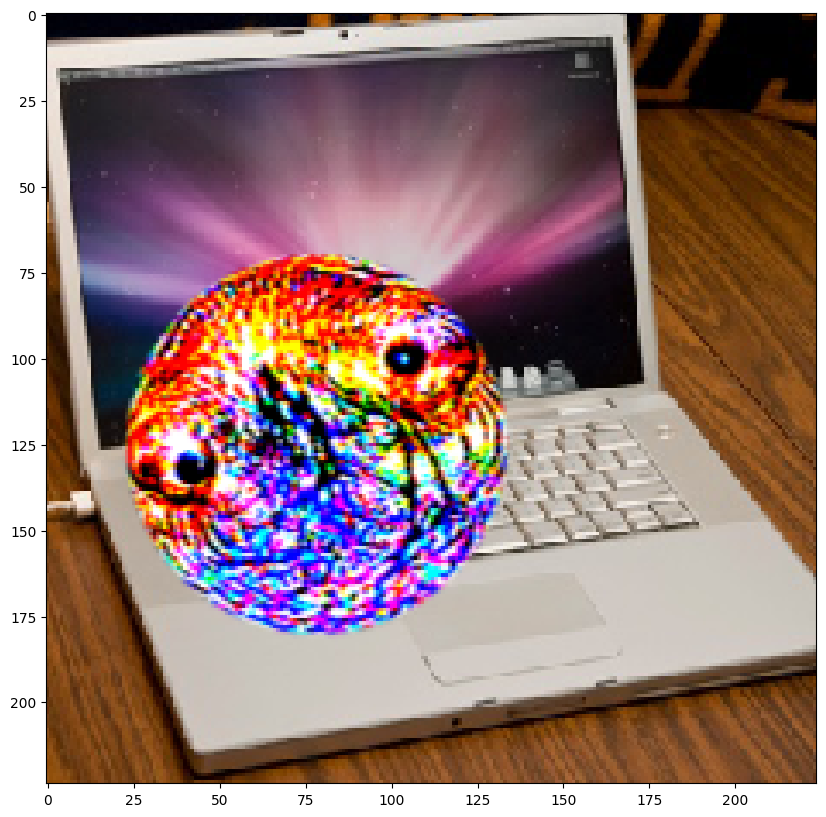

Predictions:
notebook          0.50
goldfish          0.22
mouse             0.11
laptop            0.09
computer_keyboard 0.03


In [6]:
patched_images = ap.apply_patch(images, scale=0.5)
for i in range(patched_images.shape[0]):
    predict_model(tfc, patched_images[i])

## ImageNet-Patch source images
Image data located in [imagenet-patch repository](https://github.com/pralab/ImageNet-Patch)

Prediction for image without patch:


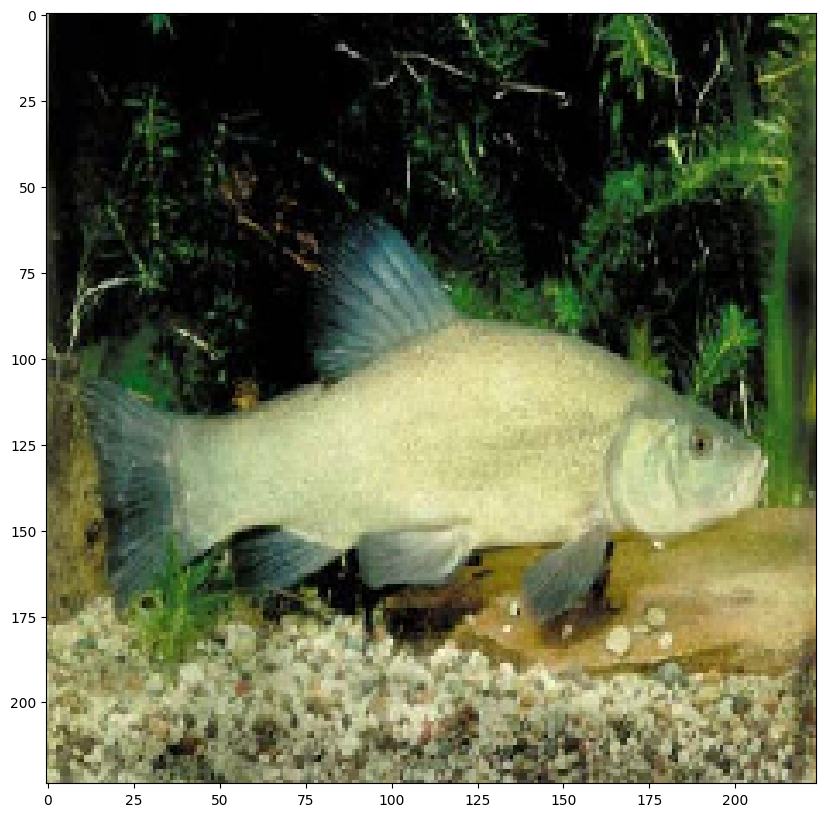

Predictions:
tench      1.00
barracouta 0.00
puffer     0.00
goldfish   0.00
reel       0.00


Adversarial Patch TensorFlow v2:   0%|          | 0/500 [00:00<?, ?it/s]

Generated patch and prediction:


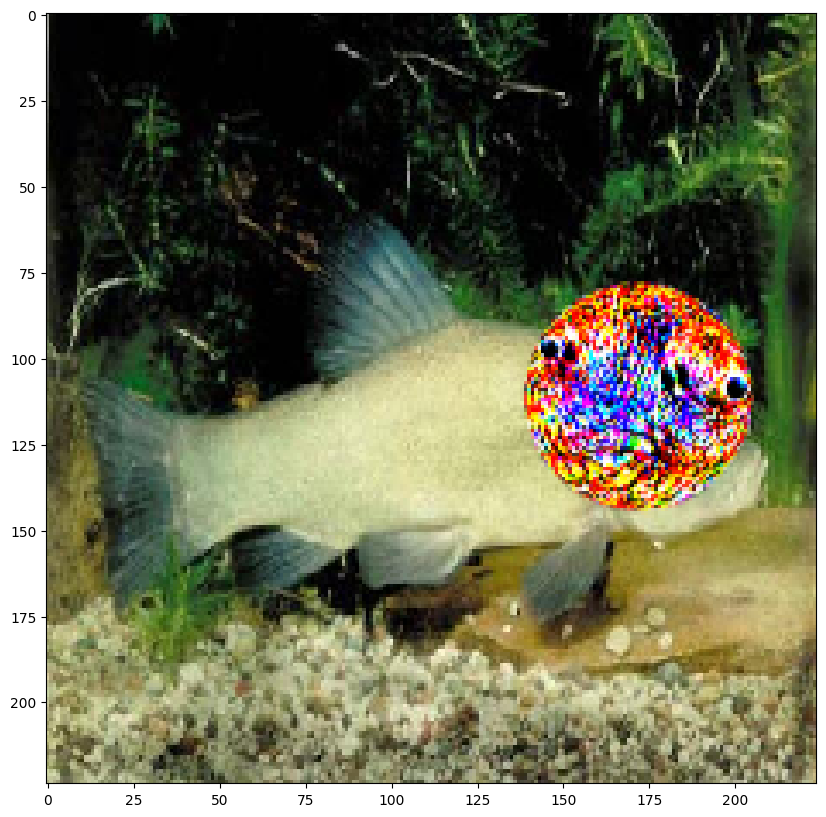

Predictions:
goldfish     0.47
puffer       0.20
ladybug      0.14
anemone_fish 0.04
sea_slug     0.03


In [8]:
images = glob.glob(os.path.join(os.getcwd(), "assets/data/n01440764")+'/*.JPEG')+\
    glob.glob(os.path.join(os.getcwd(), "assets/data/n02102040")+'/*.JPEG')+\
        glob.glob(os.path.join(os.getcwd(), "assets/data/n03028079")+'/*.JPEG')+\
            glob.glob(os.path.join(os.getcwd(), "assets/data/n02979186")+'/*.JPEG')+\
            glob.glob(os.path.join(os.getcwd(), "assets/data/n03000684")+'/*.JPEG')

images_list = list()
for image_path in images:
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images = np.vstack(images_list)

print('Prediction for image without patch:')
predict_model(tfc, images[0])


ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

print('Generated patch and prediction:')
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint))

patched_images = ap.apply_patch(images, scale=0.3)
predict_model(tfc, patched_images[0])

## ImageNet-Patch patch images

Prediction for image without patch:


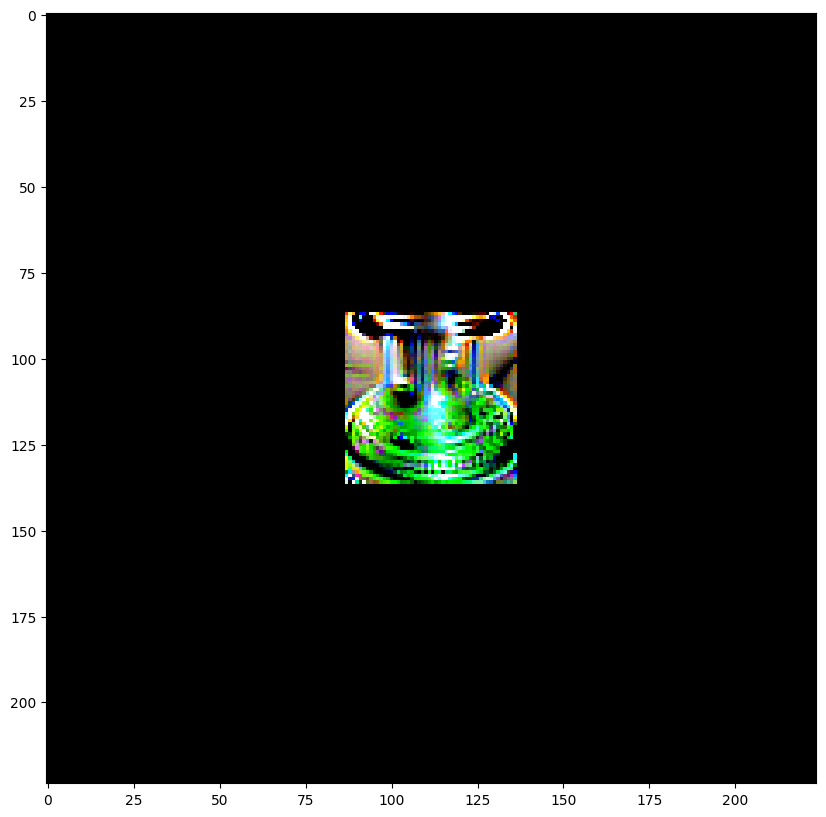

Predictions:
perfume        0.99
beaker         0.00
vase           0.00
water_bottle   0.00
soap_dispenser 0.00


Adversarial Patch TensorFlow v2:   0%|          | 0/100 [00:00<?, ?it/s]

Generated patch:
Prediction on patched image:


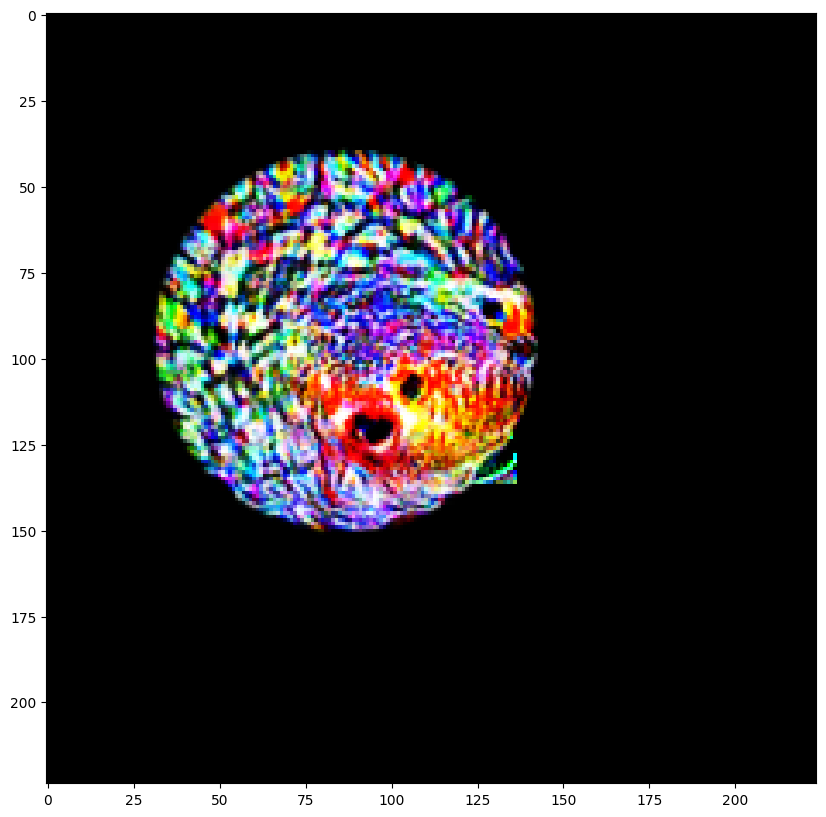

Predictions:
goldfish           1.00
puffer             0.00
tench              0.00
loggerhead         0.00
leatherback_turtle 0.00


In [ ]:
images = glob.glob(os.path.join(os.getcwd(), "assets/data/n01440764")+'/*.JPEG')+\
    glob.glob(os.path.join(os.getcwd(), "assets/data/n02102040")+'/*.JPEG')+\
        glob.glob(os.path.join(os.getcwd(), "assets/data/n03028079")+'/*.JPEG')+\
            glob.glob(os.path.join(os.getcwd(), "assets/data/n02979186")+'/*.JPEG')+\
            glob.glob(os.path.join(os.getcwd(), "assets/data/n03000684")+'/*.JPEG')

with gzip.open(os.path.join(os.getcwd(), "assets/imagenet_patch.gz"), 'rb') as f:
    imagenet_patch = pickle.load(f)
patches, targets, info = imagenet_patch
images = patches
images = images.numpy().transpose(0,2,3,1)
images = images[:, :, :, ::-1].astype(np.float32) # RGB to BGR
images = images*255

print('Prediction for image without patch:')
predict_model(tfc, images[0])


ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

print('Generated patch and prediction:')
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint))

patched_images = ap.apply_patch(images, scale=0.3)
predict_model(tfc, patched_images[0])